# Space

In [1]:
import sys
import os
import logging
import pandas as pd
import datasets
from pprint import pprint
KEY = '1-CGMLSM'
WORKSPACE_PATH = os.getcwd().split(KEY)[0]
print(WORKSPACE_PATH); os.chdir(WORKSPACE_PATH)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s:%(asctime)s:(%(filename)s@%(lineno)d %(name)s)]: %(message)s')

SPACE = {
    'DATA_RAW': f'_Data/0-Data_Raw',
    'DATA_RFT': f'_Data/1-Data_RFT',
    'DATA_CASE': f'_Data/2-Data_CASE',
    'DATA_CFDATA': f'_Data/3-Data_CFDATA',
    'DATA_SPLIT': f'_Data/4-Data_Split',
    'DATA_HFDATA': f'_Data/5-Data_HFData',
    'DATA_EXTERNAL': f'code/external',
    'CODE_FN': f'code/pipeline',
    'MODEL_ROOT': f'./_Model',
}
assert os.path.exists(SPACE['CODE_FN']), f'{SPACE["CODE_FN"]} not found'
print(SPACE['CODE_FN'])
sys.path.append(SPACE['CODE_FN'])

/home/jluo41/CGMLSM-Project/
code/pipeline


/home/jluo41/miniconda3/envs/nix/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [2]:
import os

folder = '_Data/z-Data-Inference/CgmMedalGen_dosampleFalse'
print(folder)
assert os.path.exists(folder)

# folder_output = folder + '_Eval'
# if os.path.exists(folder_output) == False: os.makedirs(folder_output)


_Data/z-Data-Inference/CgmMedalGen_dosampleFalse


In [3]:
df_predictions_all = pd.concat([pd.read_pickle(os.path.join(folder, i)) for i in sorted(os.listdir(folder)) if '.p' in i]).reset_index(drop=True)
df_predictions_all = df_predictions_all.rename(columns={'hist_289': 'Inputs', 'pred_24': 'Predict', 'real_24': 'Real'})
# df_predictions_all

In [4]:
from nn.eval.seqeval import SeqEvalForOneEvalSet

OUTPUT_LENGTH = 24

horizon_to_se = {
    '30m': [0, 6],
    '1h': [0, 12],
    '2h': [0, 24],
}
CURRENT_POINT = 289 

metric_list = [
    'rMSE', # y_pred, y_real
    'MAE', 
    
    'MAEin10',
    'RegionAccu',

    'TIR_error', # y_pred, y_real.

    # 'InputFeature', 
] 

evaluator = SeqEvalForOneEvalSet(
    setname = 'all',
    df_case_eval = df_predictions_all,
    x_hist_seq_name = 'Inputs',
    y_real_seq_name = 'Real',
    y_pred_seq_name = 'Predict',
    metric_list = metric_list,
    horizon_to_se = horizon_to_se,
)

df_case_metric, metric_list = evaluator.get_df_case_metric()


# 3m

['rMSE', 'MAE', 'MAEin10', 'RegionAccu', 'TIR_error', 'InputFeature']


In [5]:
df_case_metric.columns

Index(['PID', 'ObsDT', 'Inputs', 'Predict', 'Real', '30m_rMSE', '30m_MAE',
       '30m_MAEin10', '30m_RegionAccu', '30m_InputFeature_mean_glucose',
       '30m_InputFeature_std_glucose', '30m_InputFeature_range_glucose',
       '30m_InputFeature_coef_var', '30m_InputFeature_mean_roc',
       '30m_InputFeature_max_roc', '30m_InputFeature_tir',
       '30m_InputFeature_tar', '30m_InputFeature_tbr', '30m_TIR_error',
       '1h_rMSE', '1h_MAE', '1h_MAEin10', '1h_RegionAccu',
       '1h_InputFeature_mean_glucose', '1h_InputFeature_std_glucose',
       '1h_InputFeature_range_glucose', '1h_InputFeature_coef_var',
       '1h_InputFeature_mean_roc', '1h_InputFeature_max_roc',
       '1h_InputFeature_tir', '1h_InputFeature_tar', '1h_InputFeature_tbr',
       '1h_TIR_error', '2h_rMSE', '2h_MAE', '2h_MAEin10', '2h_RegionAccu',
       '2h_InputFeature_mean_glucose', '2h_InputFeature_std_glucose',
       '2h_InputFeature_range_glucose', '2h_InputFeature_coef_var',
       '2h_InputFeature_mean_roc', 

In [ ]:
# df_case_metric

# Metrics Calculation

In [7]:
path = '_Data/z-Data-Inference/df_case_info.parquet'
df_case = pd.read_parquet(path)
# df_case

In [8]:
print(df_case_metric.shape)
df_case_metric = pd.merge(df_case, df_case_metric, on = ['PID', 'ObsDT'], how = 'right')
print(df_case_metric.shape)
# df_case_metric

(435804, 47)
(435804, 78)


In [9]:
df_case = df_case_metric # [['PID', 'ObsDT', 'YearMonth']].drop_duplicates()

In [10]:
# df_case[['Test', 'Valid', 'Train']]# .sum()

df_case = df_case.reset_index(drop=True)
for x in [ 'In', 'Valid', 'Train']:
    df_case[x] = df_case[x].fillna(False)

for x in ['Test',  'Out']:
    df_case[x] =  df_case[x].fillna(True)


df_case = df_case[df_case['Cohort'] != '5'].reset_index(drop=True)
df_case['Cohort'] = df_case.apply(lambda x: str(x['PID'])[0], axis = 1)
df_case['Cohort'].value_counts()

Cohort
1    350596
2     78315
3      6289
5       604
Name: count, dtype: int64

In [6]:
# df_case_metric.columns

# Helper Function

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import sem, t

def get_case_inoutsplit(x):
    if x['Train'] == True:
        TVT = 'train'
    elif x['Valid'] == True:
        TVT = '1. internal test'
    elif x['Test'] == True:
        TVT = '2. temporal test'
    else:
        print(x['Train'], x['Valid'], x['Test'])
        pass 

    if x['In'] == True:
        InOut = 'In'
    elif x['Out'] == True:
        InOut = 'Out'
    else:
        pass
    split = InOut + '-' + TVT
    if InOut == 'Out':
        split = '3. held-out test'
    elif InOut == 'In':
        split = TVT
    return split


def map_age_to_group_v1(x):
    if x < 18:
        return 'O: 18'
    elif 18 <= x < 40:
        return 'A: 18-39'
    elif 40 <= x < 65:
        return 'B: 40-64'
    # elif 65 <= x < 80:
    #     return 'C: 65-79'
    # elif x >= 80:
    #     return 'D: 80+'
    elif x >= 65:
        return 'C: 65+'


def map_TIR_to_region(x):
    if 0 < x <= 0.2:
        return '5: OutRange-VeryHigh'
    elif 0.2 < x <= 0.4:
        return '4: OutRange-High'
    elif 0.4 < x <= 0.6:
        return '3: OutRange-Medium'
    elif 0.6 < x <= 0.8:
        return '2: OutRange-Low'
    elif 0.8 < x <= 1:
        return '1: OutRange-VeryLow'
    


def evaluate_df_with_metric(df, metric_name):
    # df should have a name
    metric_values = df[metric_name]
    d = {}
    d['metric_name'] = metric_name
    d['mean'] = metric_values.mean()
    d['sem'] = sem(metric_values)
    d['ci'] = d['sem'] * t.ppf((1 + 0.95) / 2, len(metric_values) - 1)

    # Number of bootstrap samples
    n_bootstrap = 10000
    bootstrap_means = np.empty(n_bootstrap)
    # Perform bootstrap sampling
    for i in range(n_bootstrap):
        # Resample with replacement
        bootstrap_sample = np.random.choice(metric_values, size=len(metric_values), replace=True)
        # Calculate the mean of the bootstrap sample
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the bootstrap confidence interval
    confidence_level = 0.95
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    confidence_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])
    # Calculate the bootstrap mean RMSE
    mean_rmse_bootstrap = np.mean(bootstrap_means)

    d['ci_bootstrap'] = confidence_interval
    d['mean_bootstrap'] = mean_rmse_bootstrap
    return d



metric_columns = [
        # 'rMSE_30Min', 'rMSE_1stH', 'rMSE_2ndH', 'rMSE_2H', 
        # 'MAE_30Min', 'MAE_1stH', 'MAE_2ndH', 'MAE_2H',
        # 'MAEWithin5_30Min', 'MAEWithin5_1stH', 'MAEWithin5_2ndH', 'MAEWithin5_2H', 
        # 'MAEWithin10_30Min', 'MAEWithin10_1stH', 'MAEWithin10_2ndH', 'MAEWithin10_2H', 
        # 'RegionAccu_30Min', 'RegionAccu_1stH', 'RegionAccu_2ndH', 'RegionAccu_2H',

       '30m_rMSE', '30m_MAE', '30m_TIR_error', '30m_MAEin10', '30m_RegionAccu',
       '1h_rMSE', '1h_MAE', '1h_TIR_error',  '1h_MAEin10', '1h_RegionAccu',
       '2h_rMSE', '2h_MAE', '2h_TIR_error',  '2h_MAEin10', '2h_RegionAccu',


    ]

def process_report_allmetrics(df, metric_columns):
    df = df.copy()
    L = []
    for metric_column in metric_columns:
        d = evaluate_df_with_metric(df, metric_column)
        L.append(d)

    df_report = pd.DataFrame(L) 
    return df_report


def process_report(df, metric_columns = metric_columns):
    df = df.copy()
    columns_y = ['30m', '1h', '2h']
    columns_x = ['rMSE', 'MAE',  'TIR_error', 'MAEin10', 'RegionAccu']

    # L = []
    # for metric_column in metric_columns:
    #     d = evaluate_df_with_metric(df, metric_column)
    #     L.append(d)
    # df_report = pd.DataFrame(L) 

    # Calculate mean, SEM, and counts
    df_mean = df[metric_columns].mean().reset_index()
    df_sem = df[metric_columns].sem().reset_index()
    df_count = df[metric_columns].count().reset_index()



    # Calculate 95% CI
    confidence_level = 0.95
    df_ci = df_sem.copy()
    for i in range(len(df_ci)):
        n = df_count.iloc[i, 1]
        critical_t = t.ppf((1 + confidence_level) / 2, n - 1)
        df_ci.iloc[i, 1] = df_sem.iloc[i, 1] * critical_t

    # Organize data
    d = {'mean': df_mean, 'sem': df_sem, 'ci': df_ci}
    results = {}
    # results['size'] = len(df)

    # print('the size of the dataset is:', len(df), 'human', df['PID'].nunique())
    for name, df_r in d.items():
        df_r.rename(columns={0: 'Score', 'index': 'FullMetric'}, inplace=True)
        df_r['horizon'] = df_r['FullMetric'].apply(lambda x: x.split('_')[0].strip())
        df_r['Metric']  = df_r['FullMetric'].apply(lambda x: '_'.join(x.split('_')[1:]).strip())
        df_r = df_r.pivot(index='horizon', columns='Metric', values='Score')
        df_r = df_r[columns_x].T
        df_r = df_r[columns_y]
        results[name] = df_r
    return results


def process_performance_output(df, 
                               subcolumns_list, 
                               focus_on_list, 
                               metric, 
                               horizon):
    L_mean = []
    L_sem  = []
    L_ci   = []
    for subcolumns in subcolumns_list:
        for subname, df_sub in df.groupby(subcolumns):
            name = ['.'.join([str(s) for s in i]) for i in list(zip(subcolumns, subname))]
            name = '_'.join(name)
            if len(focus_on_list) > 0:
                indicator = np.mean([focus_on in name for focus_on in focus_on_list])
                if indicator != 1: continue

            print('current name is :', name)
            results = process_report(df_sub)

            df_r = results['mean']
            v = df_r.loc[metric, horizon]
            metric_name = '-'.join([metric, horizon])
            d = {'name': name, metric_name: v}
            for k, v in list(zip(subcolumns, subname)): d[k] = v
            L_mean.append(d)

            df_r = results['sem']
            v = df_r.loc[metric, horizon]
            metric_name = '-'.join([metric, horizon])
            d = {'name': name, metric_name: v}
            for k, v in list(zip(subcolumns, subname)): d[k] = v
            L_sem.append(d)


            df_r = results['ci']
            v = df_r.loc[metric, horizon]
            metric_name = '-'.join([metric, horizon])
            d = {'name': name, metric_name: v}
            for k, v in list(zip(subcolumns, subname)): d[k] = v
            L_ci.append(d)
            
    df_mean = pd.DataFrame(L_mean)
    df_sem = pd.DataFrame(L_sem)
    df_ci = pd.DataFrame(L_ci)

    report_results = {'mean': df_mean, 'sem': df_sem, 'ci': df_ci}
    return report_results


In [12]:
################ new columns
df_case['InOutSplit'] = df_case.apply(get_case_inoutsplit, axis = 1)
df_case['InOut'] = df_case['InOutSplit'].apply(lambda x: x.split('-')[0])
df_case['Hour'] = df_case['ObsDT'].dt.hour
print(df_case['InOutSplit'].value_counts().sort_index())
print(df_case['Hour'].value_counts().sort_index())

InOutSplit
1. internal test    128236
2. temporal test    142055
3. held-out test    165513
Name: count, dtype: int64
Hour
0     18247
1     18148
2     18218
3     18432
4     18239
5     18106
6     18402
7     18139
8     18205
9     18304
10    18244
11    18323
12    18339
13    18349
14    18180
15    18213
16    17769
17    17946
18    17936
19    18095
20    18090
21    17934
22    17995
23    17951
Name: count, dtype: int64


In [13]:
# [i for i in df_case.columns] 
df_case['Bf24hOutRange'] = df_case['Bf24hCGMinfo:TIR'].apply(lambda x: map_TIR_to_region(x))
print(df_case['Bf24hOutRange'].value_counts().sort_index())
# df_case['Age'].value_counts()
df_case['AgeGroup'] = df_case['Age'].apply(map_age_to_group_v1)
# print(df_case['AgeGroup'].value_counts().sort_index())
# print(df_case['Gender'].value_counts())
df_case['Sex'] = df_case['Gender'].map({1: 'Female', 2: 'Male'})#.value_counts()
df_case['DiabetesType'] = df_case['DiseaseType'].map({1: 'Type 1 Diabetes', 2: 'Type 2 Diabetes'})#.value_counts()
# print(df_case['Sex'].value_counts())
df_case['AgeSexGroup'] = df_case['AgeGroup'] + ' ' + df_case['Sex']

Bf24hOutRange
1: OutRange-VeryLow     162118
2: OutRange-Low         125337
3: OutRange-Medium       81574
4: OutRange-High         41331
5: OutRange-VeryHigh     19199
Name: count, dtype: int64


In [14]:
df = df_case

processed_data = process_report(df)
for k, v in processed_data.items():
    print(k)
    display(v)

mean


horizon,30m,1h,2h
Metric,,,
rMSE,8.307735,15.259063,26.217441
MAE,6.988327,12.744204,21.886598
TIR_error,0.046693,0.084877,0.141764
MAEin10,0.791819,0.621758,0.453315
RegionAccu,0.936373,0.886134,0.814713


sem


horizon,30m,1h,2h
Metric,,,
rMSE,0.012426,0.021538,0.033878
MAE,0.010625,0.018307,0.028987
TIR_error,0.000230,0.000296,0.000358
MAEin10,0.000414,0.000471,0.000439
RegionAccu,0.000266,0.000338,0.000403


ci


horizon,30m,1h,2h
Metric,,,
rMSE,0.024354,0.042214,0.066400
MAE,0.020825,0.035881,0.056813
TIR_error,0.000451,0.000580,0.000701
MAEin10,0.000811,0.000924,0.000860
RegionAccu,0.000522,0.000662,0.000789


In [15]:
df_case.columns

Index(['PID', 'ObsDT', 'Gender', 'YearOfBirth', 'DiseaseType', 'cohort', 'Age',
       'Bf24hCGMinfo:VeryLow', 'Bf24hCGMinfo:Low', 'Bf24hCGMinfo:TIR',
       'Bf24hCGMinfo:High', 'Bf24hCGMinfo:VeryHigh', 'Bf24hCGMinfo:TAR',
       'Bf24hCGMinfo:TBR', 'Bf24hCGMinfo:ModeValue',
       'Bf24hCGMinfo:ModePercent', 'Bf24hCGMinfo:recnum',
       'Af2hCGMinfo:VeryLow', 'Af2hCGMinfo:Low', 'Af2hCGMinfo:TIR',
       'Af2hCGMinfo:High', 'Af2hCGMinfo:VeryHigh', 'Af2hCGMinfo:TAR',
       'Af2hCGMinfo:TBR', 'Af2hCGMinfo:ModeValue', 'Af2hCGMinfo:ModePercent',
       'Af2hCGMinfo:recnum', 'Out', 'In', 'Test', 'Valid', 'Train', 'Cohort',
       'Inputs', 'Predict', 'Real', '30m_rMSE', '30m_MAE', '30m_MAEin10',
       '30m_RegionAccu', '30m_InputFeature_mean_glucose',
       '30m_InputFeature_std_glucose', '30m_InputFeature_range_glucose',
       '30m_InputFeature_coef_var', '30m_InputFeature_mean_roc',
       '30m_InputFeature_max_roc', '30m_InputFeature_tir',
       '30m_InputFeature_tar', '30m_InputF

# Disease and InOutSplit

In [22]:
df = df_case

## 1.1 rMSE

In [16]:
###############
metric = 'rMSE'
###############

subcolumns_list = [
    ['InOutSplit',  'DiabetesType']
]
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
index_list = ['In-Valid', 'In-Test', 'Out']


final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


Topic = metric

d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = ['DiabetesType', 'InOutSplit'], columns = 'ValueName', values = 'Value')
    print(dfx.columns)
    custom_order = [f'{metric}-{i}' for i in ['30m', '1h', '2h']]

    dfx = dfx.reindex(columns=custom_order)
    # dfx.to_pickle(path)
    dfx.loc[:, custom_order] = dfx.loc[:, custom_order].round(3)
    results[name] = dfx

    new_path = path.replace('.p', f'_{name}.p')
    # dfx.to_pickle(new_path)
    # print(new_path)
    display(dfx)


# name = 'ci' # 'mean'
# results[name].to_clipboard()

df_mean = results['mean']
df_ci = results['ci']

df_full = df_mean.copy()
for column in custom_order:
    df_full[column] = df_mean[column].astype(str) + " (" + df_ci[column].astype(str) + ")"

# df_full.to_clipboard()  
df_full

current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSp

ValueName                         rMSE-30m  rMSE-1h  rMSE-2h
DiabetesType    InOutSplit                                  
Type 1 Diabetes 1. internal test     8.403   16.049   28.277
                2. temporal test     9.155   17.013   29.426
                3. held-out test     8.926   16.905   29.812
Type 2 Diabetes 1. internal test     7.441   13.418   22.649
                2. temporal test     8.025   14.073   23.216
                3. held-out test     7.772   13.877   23.494

Index(['rMSE-1h', 'rMSE-2h', 'rMSE-30m'], dtype='object', name='ValueName')


ValueName                         rMSE-30m  rMSE-1h  rMSE-2h
DiabetesType    InOutSplit                                  
Type 1 Diabetes 1. internal test     0.066    0.118    0.188
                2. temporal test     0.068    0.118    0.184
                3. held-out test     0.056    0.101    0.160
Type 2 Diabetes 1. internal test     0.055    0.094    0.147
                2. temporal test     0.058    0.095    0.143
                3. held-out test     0.055    0.091    0.143

ValueName                              rMSE-30m         rMSE-1h  \
DiabetesType    InOutSplit                                        
Type 1 Diabetes 1. internal test  8.403 (0.066)  16.049 (0.118)   
                2. temporal test  9.155 (0.068)  17.013 (0.118)   
                3. held-out test  8.926 (0.056)  16.905 (0.101)   
Type 2 Diabetes 1. internal test  7.441 (0.055)  13.418 (0.094)   
                2. temporal test  8.025 (0.058)  14.073 (0.095)   
                3. held-out test  7.772 (0.055)  13.877 (0.091)   

ValueName                                rMSE-2h  
DiabetesType    InOutSplit                        
Type 1 Diabetes 1. internal test  28.277 (0.188)  
                2. temporal test  29.426 (0.184)  
                3. held-out test   29.812 (0.16)  
Type 2 Diabetes 1. internal test  22.649 (0.147)  
                2. temporal test  23.216 (0.143)  
                3. held-out test  23.494 (0.143)

## 1.2 MAE

In [17]:
###############
metric = 'MAE'
###############

subcolumns_list = [
    ['InOutSplit',  'DiabetesType']
]
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
index_list = ['In-Valid', 'In-Test', 'Out']


final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


Topic = metric

d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = ['DiabetesType', 'InOutSplit'], columns = 'ValueName', values = 'Value')
    print(dfx.columns)
    custom_order = [f'{metric}-{i}' for i in ['30m', '1h', '2h']]

    dfx = dfx.reindex(columns=custom_order)
    # dfx.to_pickle(path)
    dfx.loc[:, custom_order] = dfx.loc[:, custom_order].round(3)
    results[name] = dfx

    new_path = path.replace('.p', f'_{name}.p')
    # dfx.to_pickle(new_path)
    # print(new_path)
    display(dfx)


# name = 'ci' # 'mean'
# results[name].to_clipboard()

df_mean = results['mean']
df_ci = results['ci']

df_full = df_mean.copy()
for column in custom_order:
    df_full[column] = df_mean[column].astype(str) + " (" + df_ci[column].astype(str) + ")"

# df_full.to_clipboard()  
df_full

current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSp

ValueName                         MAE-30m  MAE-1h  MAE-2h
DiabetesType    InOutSplit                               
Type 1 Diabetes 1. internal test    7.001  13.295  23.461
                2. temporal test    7.691  14.205  24.552
                3. held-out test    7.497  14.099  24.889
Type 2 Diabetes 1. internal test    6.246  11.190  18.876
                2. temporal test    6.805  11.833  19.472
                3. held-out test    6.571  11.640  19.678

Index(['MAE-1h', 'MAE-2h', 'MAE-30m'], dtype='object', name='ValueName')


ValueName                         MAE-30m  MAE-1h  MAE-2h
DiabetesType    InOutSplit                               
Type 1 Diabetes 1. internal test    0.056   0.099   0.160
                2. temporal test    0.058   0.101   0.158
                3. held-out test    0.048   0.085   0.138
Type 2 Diabetes 1. internal test    0.047   0.080   0.125
                2. temporal test    0.050   0.081   0.123
                3. held-out test    0.047   0.078   0.123

ValueName                               MAE-30m          MAE-1h  \
DiabetesType    InOutSplit                                        
Type 1 Diabetes 1. internal test  7.001 (0.056)  13.295 (0.099)   
                2. temporal test  7.691 (0.058)  14.205 (0.101)   
                3. held-out test  7.497 (0.048)  14.099 (0.085)   
Type 2 Diabetes 1. internal test  6.246 (0.047)    11.19 (0.08)   
                2. temporal test   6.805 (0.05)  11.833 (0.081)   
                3. held-out test  6.571 (0.047)   11.64 (0.078)   

ValueName                                 MAE-2h  
DiabetesType    InOutSplit                        
Type 1 Diabetes 1. internal test   23.461 (0.16)  
                2. temporal test  24.552 (0.158)  
                3. held-out test  24.889 (0.138)  
Type 2 Diabetes 1. internal test  18.876 (0.125)  
                2. temporal test  19.472 (0.123)  
                3. held-out test  19.678 (0.123)

In [18]:
df.columns

Index(['PID', 'ObsDT', 'Gender', 'YearOfBirth', 'DiseaseType', 'cohort', 'Age',
       'Bf24hCGMinfo:VeryLow', 'Bf24hCGMinfo:Low', 'Bf24hCGMinfo:TIR',
       'Bf24hCGMinfo:High', 'Bf24hCGMinfo:VeryHigh', 'Bf24hCGMinfo:TAR',
       'Bf24hCGMinfo:TBR', 'Bf24hCGMinfo:ModeValue',
       'Bf24hCGMinfo:ModePercent', 'Bf24hCGMinfo:recnum',
       'Af2hCGMinfo:VeryLow', 'Af2hCGMinfo:Low', 'Af2hCGMinfo:TIR',
       'Af2hCGMinfo:High', 'Af2hCGMinfo:VeryHigh', 'Af2hCGMinfo:TAR',
       'Af2hCGMinfo:TBR', 'Af2hCGMinfo:ModeValue', 'Af2hCGMinfo:ModePercent',
       'Af2hCGMinfo:recnum', 'Out', 'In', 'Test', 'Valid', 'Train', 'Cohort',
       'Inputs', 'Predict', 'Real', '30m_rMSE', '30m_MAE', '30m_MAEin10',
       '30m_RegionAccu', '30m_InputFeature_mean_glucose',
       '30m_InputFeature_std_glucose', '30m_InputFeature_range_glucose',
       '30m_InputFeature_coef_var', '30m_InputFeature_mean_roc',
       '30m_InputFeature_max_roc', '30m_InputFeature_tir',
       '30m_InputFeature_tar', '30m_InputF

## 1.3 MAE within 10

In [19]:
###############
metric = 'MAEin10'
###############

subcolumns_list = [
    ['InOutSplit',  'DiabetesType']
]
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
index_list = ['In-Valid', 'In-Test', 'Out']


final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


Topic = metric

d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = ['DiabetesType', 'InOutSplit'], columns = 'ValueName', values = 'Value')
    print(dfx.columns)
    custom_order = [f'{metric}-{i}' for i in ['30m', '1h', '2h']]

    dfx = dfx.reindex(columns=custom_order)
    # dfx.to_pickle(path)
    dfx.loc[:, custom_order] = dfx.loc[:, custom_order].round(3)
    results[name] = dfx

    new_path = path.replace('.p', f'_{name}.p')
    # dfx.to_pickle(new_path)
    # print(new_path)
    display(dfx)


# name = 'ci' # 'mean'
# results[name].to_clipboard()

df_mean = results['mean']
df_ci = results['ci']

df_full = df_mean.copy()
for column in custom_order:
    df_full[column] = df_mean[column].astype(str) + " (" + df_ci[column].astype(str) + ")"

# df_full.to_clipboard()  
df_full

current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSp

ValueName                         MAEin10-30m  MAEin10-1h  MAEin10-2h
DiabetesType    InOutSplit                                           
Type 1 Diabetes 1. internal test        0.792       0.613       0.438
                2. temporal test        0.768       0.591       0.423
                3. held-out test        0.772       0.588       0.413
Type 2 Diabetes 1. internal test        0.818       0.658       0.493
                2. temporal test        0.799       0.640       0.480
                3. held-out test        0.807       0.646       0.480

Index(['MAEin10-1h', 'MAEin10-2h', 'MAEin10-30m'], dtype='object', name='ValueName')


ValueName                         MAEin10-30m  MAEin10-1h  MAEin10-2h
DiabetesType    InOutSplit                                           
Type 1 Diabetes 1. internal test        0.002       0.002       0.002
                2. temporal test        0.002       0.002       0.002
                3. held-out test        0.002       0.002       0.002
Type 2 Diabetes 1. internal test        0.002       0.002       0.002
                2. temporal test        0.002       0.002       0.002
                3. held-out test        0.002       0.002       0.002

ValueName                           MAEin10-30m     MAEin10-1h     MAEin10-2h
DiabetesType    InOutSplit                                                   
Type 1 Diabetes 1. internal test  0.792 (0.002)  0.613 (0.002)  0.438 (0.002)
                2. temporal test  0.768 (0.002)  0.591 (0.002)  0.423 (0.002)
                3. held-out test  0.772 (0.002)  0.588 (0.002)  0.413 (0.002)
Type 2 Diabetes 1. internal test  0.818 (0.002)  0.658 (0.002)  0.493 (0.002)
                2. temporal test  0.799 (0.002)   0.64 (0.002)   0.48 (0.002)
                3. held-out test  0.807 (0.002)  0.646 (0.002)   0.48 (0.002)

## RegionAccu

In [20]:
###############
metric = 'RegionAccu'
###############

subcolumns_list = [
    ['InOutSplit',  'DiabetesType']
]
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
index_list = ['In-Valid', 'In-Test', 'Out']


final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


Topic = metric

d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = ['DiabetesType', 'InOutSplit'], columns = 'ValueName', values = 'Value')
    print(dfx.columns)
    custom_order = [f'{metric}-{i}' for i in ['30m', '1h', '2h']]

    dfx = dfx.reindex(columns=custom_order)
    # dfx.to_pickle(path)
    dfx.loc[:, custom_order] = dfx.loc[:, custom_order].round(3)
    results[name] = dfx

    new_path = path.replace('.p', f'_{name}.p')
    dfx.to_pickle(new_path)
    # print(new_path)
    display(dfx)


# name = 'ci' # 'mean'
# results[name].to_clipboard()

df_mean = results['mean']
df_ci = results['ci']

df_full = df_mean.copy()
for column in custom_order:
    df_full[column] = df_mean[column].astype(str) + " (" + df_ci[column].astype(str) + ")"

# df_full.to_clipboard()  
df_full

current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.2. temporal test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 1 Diabetes
current name is : InOutSplit.3. held-out test_DiabetesType.Type 2 Diabetes
current name is : InOutSplit.1. internal test_DiabetesType.Type 1 Diabetes
current name is : InOutSp

ValueName                         RegionAccu-30m  RegionAccu-1h  RegionAccu-2h
DiabetesType    InOutSplit                                                    
Type 1 Diabetes 1. internal test           0.935          0.880          0.802
                2. temporal test           0.928          0.872          0.793
                3. held-out test           0.925          0.865          0.779
Type 2 Diabetes 1. internal test           0.947          0.905          0.846
                2. temporal test           0.944          0.902          0.843
                3. held-out test           0.941          0.896          0.833

Index(['RegionAccu-1h', 'RegionAccu-2h', 'RegionAccu-30m'], dtype='object', name='ValueName')


ValueName                         RegionAccu-30m  RegionAccu-1h  RegionAccu-2h
DiabetesType    InOutSplit                                                    
Type 1 Diabetes 1. internal test           0.001          0.002          0.002
                2. temporal test           0.001          0.002          0.002
                3. held-out test           0.001          0.002          0.002
Type 2 Diabetes 1. internal test           0.001          0.002          0.002
                2. temporal test           0.001          0.002          0.002
                3. held-out test           0.001          0.002          0.002

ValueName                        RegionAccu-30m  RegionAccu-1h  RegionAccu-2h
DiabetesType    InOutSplit                                                   
Type 1 Diabetes 1. internal test  0.935 (0.001)   0.88 (0.002)  0.802 (0.002)
                2. temporal test  0.928 (0.001)  0.872 (0.002)  0.793 (0.002)
                3. held-out test  0.925 (0.001)  0.865 (0.002)  0.779 (0.002)
Type 2 Diabetes 1. internal test  0.947 (0.001)  0.905 (0.002)  0.846 (0.002)
                2. temporal test  0.944 (0.001)  0.902 (0.002)  0.843 (0.002)
                3. held-out test  0.941 (0.001)  0.896 (0.002)  0.833 (0.002)

# 2. Patient Subgroup 

## 1. Age rMSE-2H

In [34]:
# subcolumn = 'DiseaseType' # 'AgeGroup'
Topic = 'AgeGroup'
subcolumns_list = [['DiabetesType', 'InOutSplit',   Topic]]
metric = 'rMSE'
focus_on_list = []
# horizon_list = ['30Min', '1stH', '2H']
horizon_list = ['2h']
index_list = ['In-Valid', 'In-Test', 'Out']

final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = [Topic], columns = ['ValueName', 'DiabetesType', 'InOutSplit'], values = 'Value')
    # custom_order = [f'{metric}-{i}' for i in ['30Min', '1stH', '2H']]
    # dfx = dfx.reindex(columns=custom_order)
    results[name] = dfx
    print(name)
    display(dfx)


current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_AgeGroup.A: 18-39
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_AgeGroup.B: 40-64
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_AgeGroup.C: 65+
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.2. temporal test_AgeGroup.A: 18-39
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.2. temporal test_AgeGroup.B: 40-64
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.2. temporal test_AgeGroup.C: 65+
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.3. held-out test_AgeGroup.A: 18-39
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.3. held-out test_AgeGroup.B: 40-64
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.3. held-out test_AgeGroup.C: 65+
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.1. internal test_AgeGroup.A: 18-39
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.1. internal test_A

ValueName             rMSE-2h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
AgeGroup                                                          
A: 18-39            30.848362        32.869145        31.782795   
B: 40-64            27.666152        28.397256        30.307352   
C: 65+              24.923061        25.310443        24.771361   

ValueName                                                        
DiabetesType  Type 2 Diabetes                                    
InOutSplit   1. internal test 2. temporal test 3. held-out test  
AgeGroup                                                         
A: 18-39            23.271554        24.631681        31.020339  
B: 40-64            22.860342        23.417290        22.772938  
C: 65+              22.182515        22.618564        23.914221

ci


ValueName             rMSE-2h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
AgeGroup                                                          
A: 18-39             0.331187         0.330374         0.286216   
B: 40-64             0.283096         0.274794         0.238764   
C: 65+               0.361046         0.342832         0.297081   

ValueName                                                        
DiabetesType  Type 2 Diabetes                                    
InOutSplit   1. internal test 2. temporal test 3. held-out test  
AgeGroup                                                         
A: 18-39             0.577991         0.576415         0.873144  
B: 40-64             0.192939         0.188143         0.169424  
C: 65+               0.244425         0.237075         0.263623

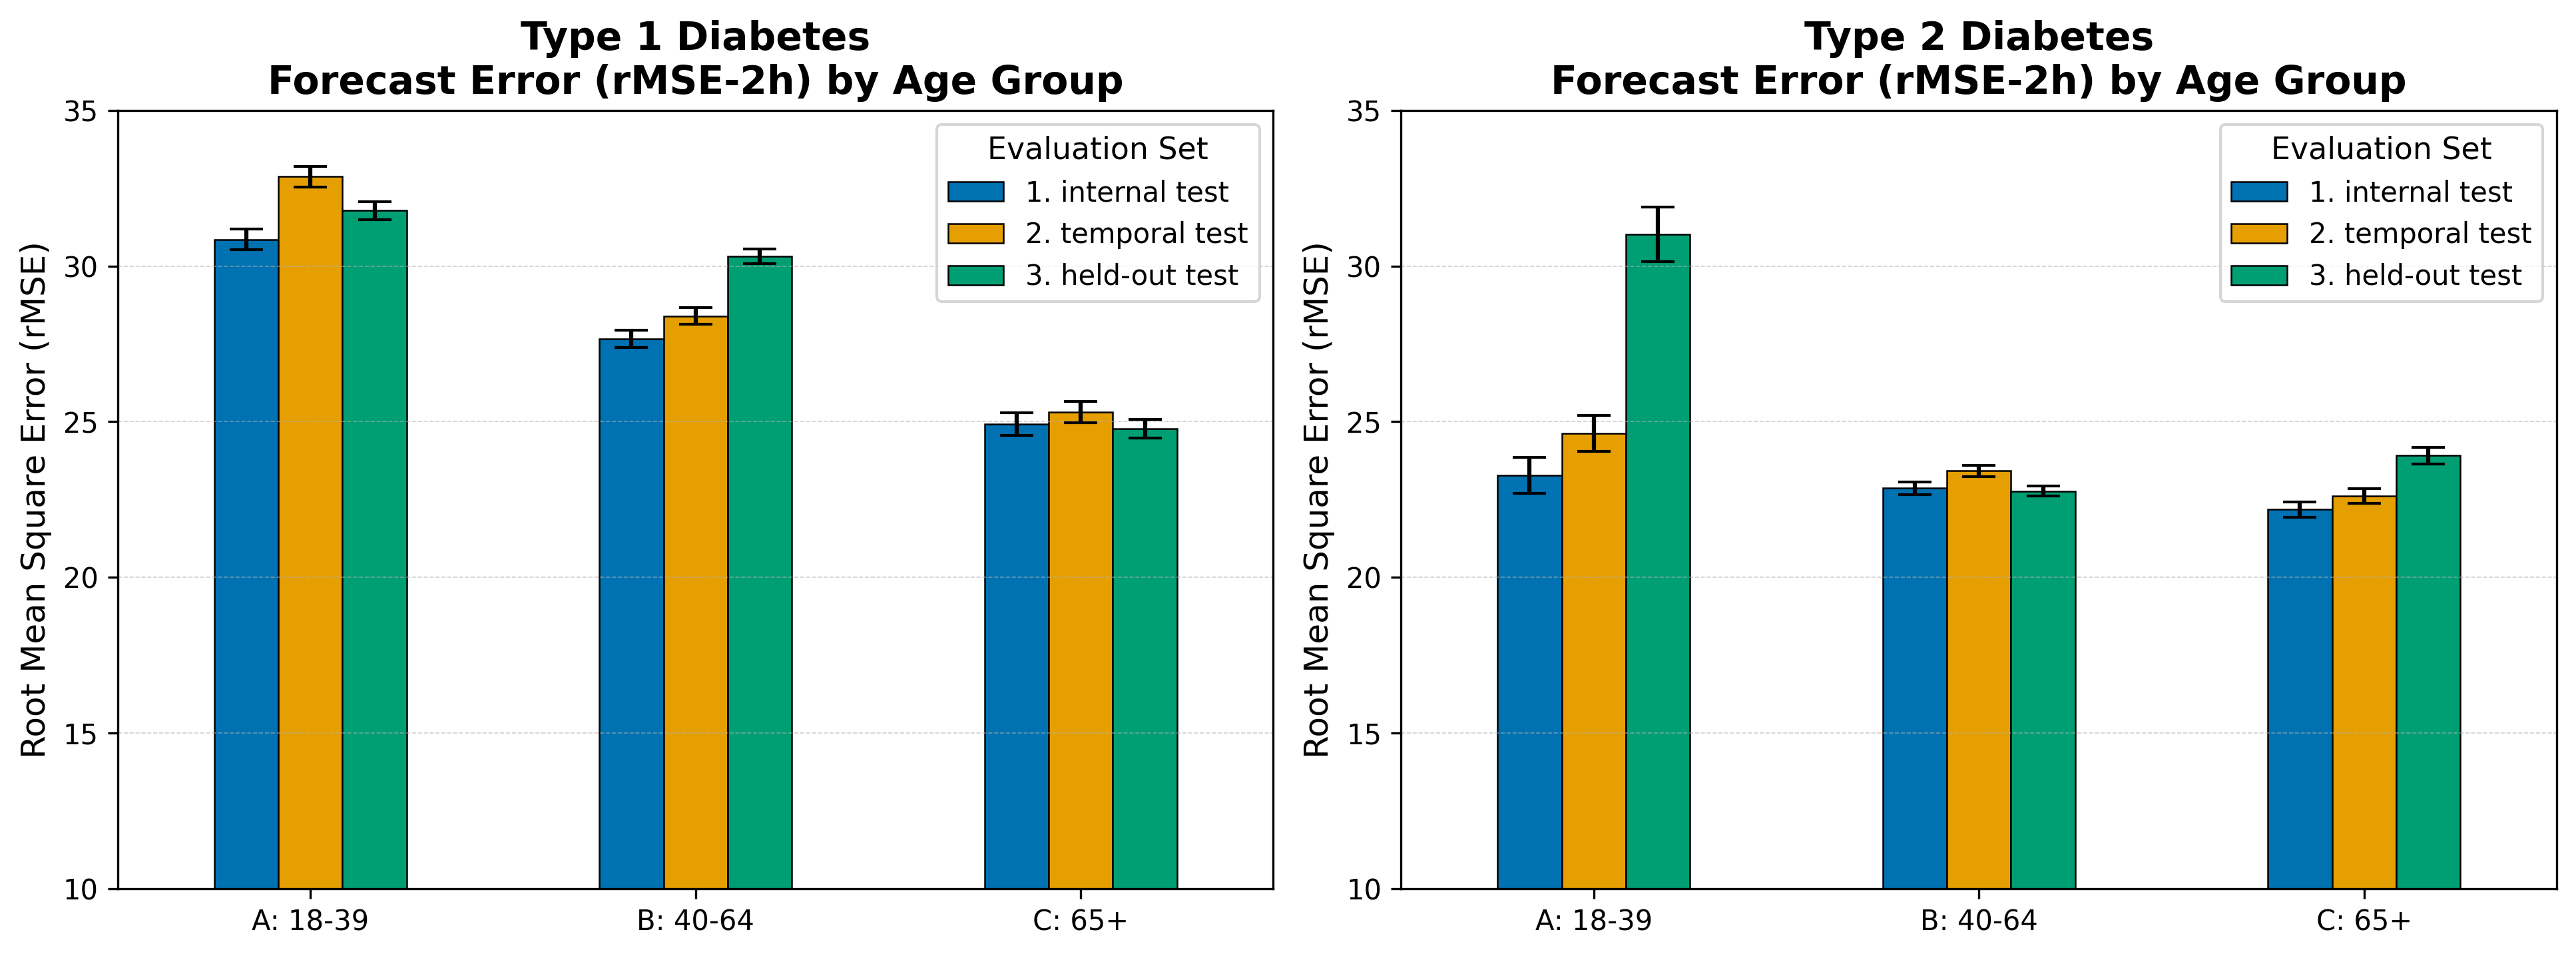

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define better color palette (colorblind-friendly)
colors = ['#0072B2', '#E69F00', '#009E73']  # Blue, Orange, Green

# Define your variables
metric_horizon = 'rMSE-2h'
min_y = 10
max_y = 35

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

for idx, ax in enumerate(axs):
    diabetes_type = 'Type 1 Diabetes' if idx == 0 else 'Type 2 Diabetes'

    # Select mean and error data
    dfx = results['mean']
    dfx_select = dfx[metric_horizon][diabetes_type]
    dfx_ci = results['ci']
    error = dfx_ci[metric_horizon][diabetes_type]

    # Plot bars
    dfx_select.plot(
        kind='bar',
        yerr=error,
        ax=ax,
        capsize=6,
        color=colors,
        edgecolor='black',
        linewidth=0.6
    )

    # Styling
    ax.set_title(
        f"{diabetes_type}\nForecast Error (rMSE-2h) by Age Group",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("Root Mean Square Error (rMSE)", fontsize=12)
    ax.set_ylim([min_y, max_y])
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(title="Evaluation Set", fontsize=10, title_fontsize=11, loc='upper right')

    # Optional: add grid
    ax.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.6)

# Final layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

## 2. Gender  rMSE-2h

In [36]:
# subcolumn = 'DiseaseType' # 'AgeGroup'
Topic = 'Sex'
subcolumns_list = [['DiabetesType', 'InOutSplit',   Topic]]
metric = 'rMSE'
focus_on_list = []
# horizon_list = ['30Min', '1stH', '2H']
horizon_list = ['2h']
index_list = ['In-Valid', 'In-Test', 'Out']

final_results = {'mean': [], 'sem': [], 'ci': []}
for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns = {value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci  = pd.concat(final_results['ci'])


d = {'mean': df_mean, 'ci': df_ci}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index = [Topic], columns = ['ValueName', 'DiabetesType', 'InOutSplit'], values = 'Value')
    # custom_order = [f'{metric}-{i}' for i in ['30Min', '1stH', '2H']]
    # dfx = dfx.reindex(columns=custom_order)
    results[name] = dfx
    print(name)
    display(dfx)

current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Sex.Female
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Sex.Male
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.2. temporal test_Sex.Female
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.2. temporal test_Sex.Male
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.3. held-out test_Sex.Female
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.3. held-out test_Sex.Male
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.1. internal test_Sex.Female
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.1. internal test_Sex.Male
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.2. temporal test_Sex.Female
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.2. temporal test_Sex.Male
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.3. held-out test_Sex.Female
current name is : DiabetesType.Type 2 Diabetes_InOutSplit.3. hel

ValueName             rMSE-2h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Sex                                                               
Female              28.698430        30.204769        31.887475   
Male                27.800112        28.546147        27.000779   

ValueName                                                        
DiabetesType  Type 2 Diabetes                                    
InOutSplit   1. internal test 2. temporal test 3. held-out test  
Sex                                                              
Female              24.126993        24.360067        24.721116  
Male                21.781525        22.562161        23.088376

ci


ValueName             rMSE-2h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Sex                                                               
Female               0.260217         0.258448         0.224494   
Male                 0.271062         0.262359         0.220834   

ValueName                                                        
DiabetesType  Type 2 Diabetes                                    
InOutSplit   1. internal test 2. temporal test 3. held-out test  
Sex                                                              
Female               0.259580         0.251744         0.299404  
Male                 0.175643         0.172077         0.162077

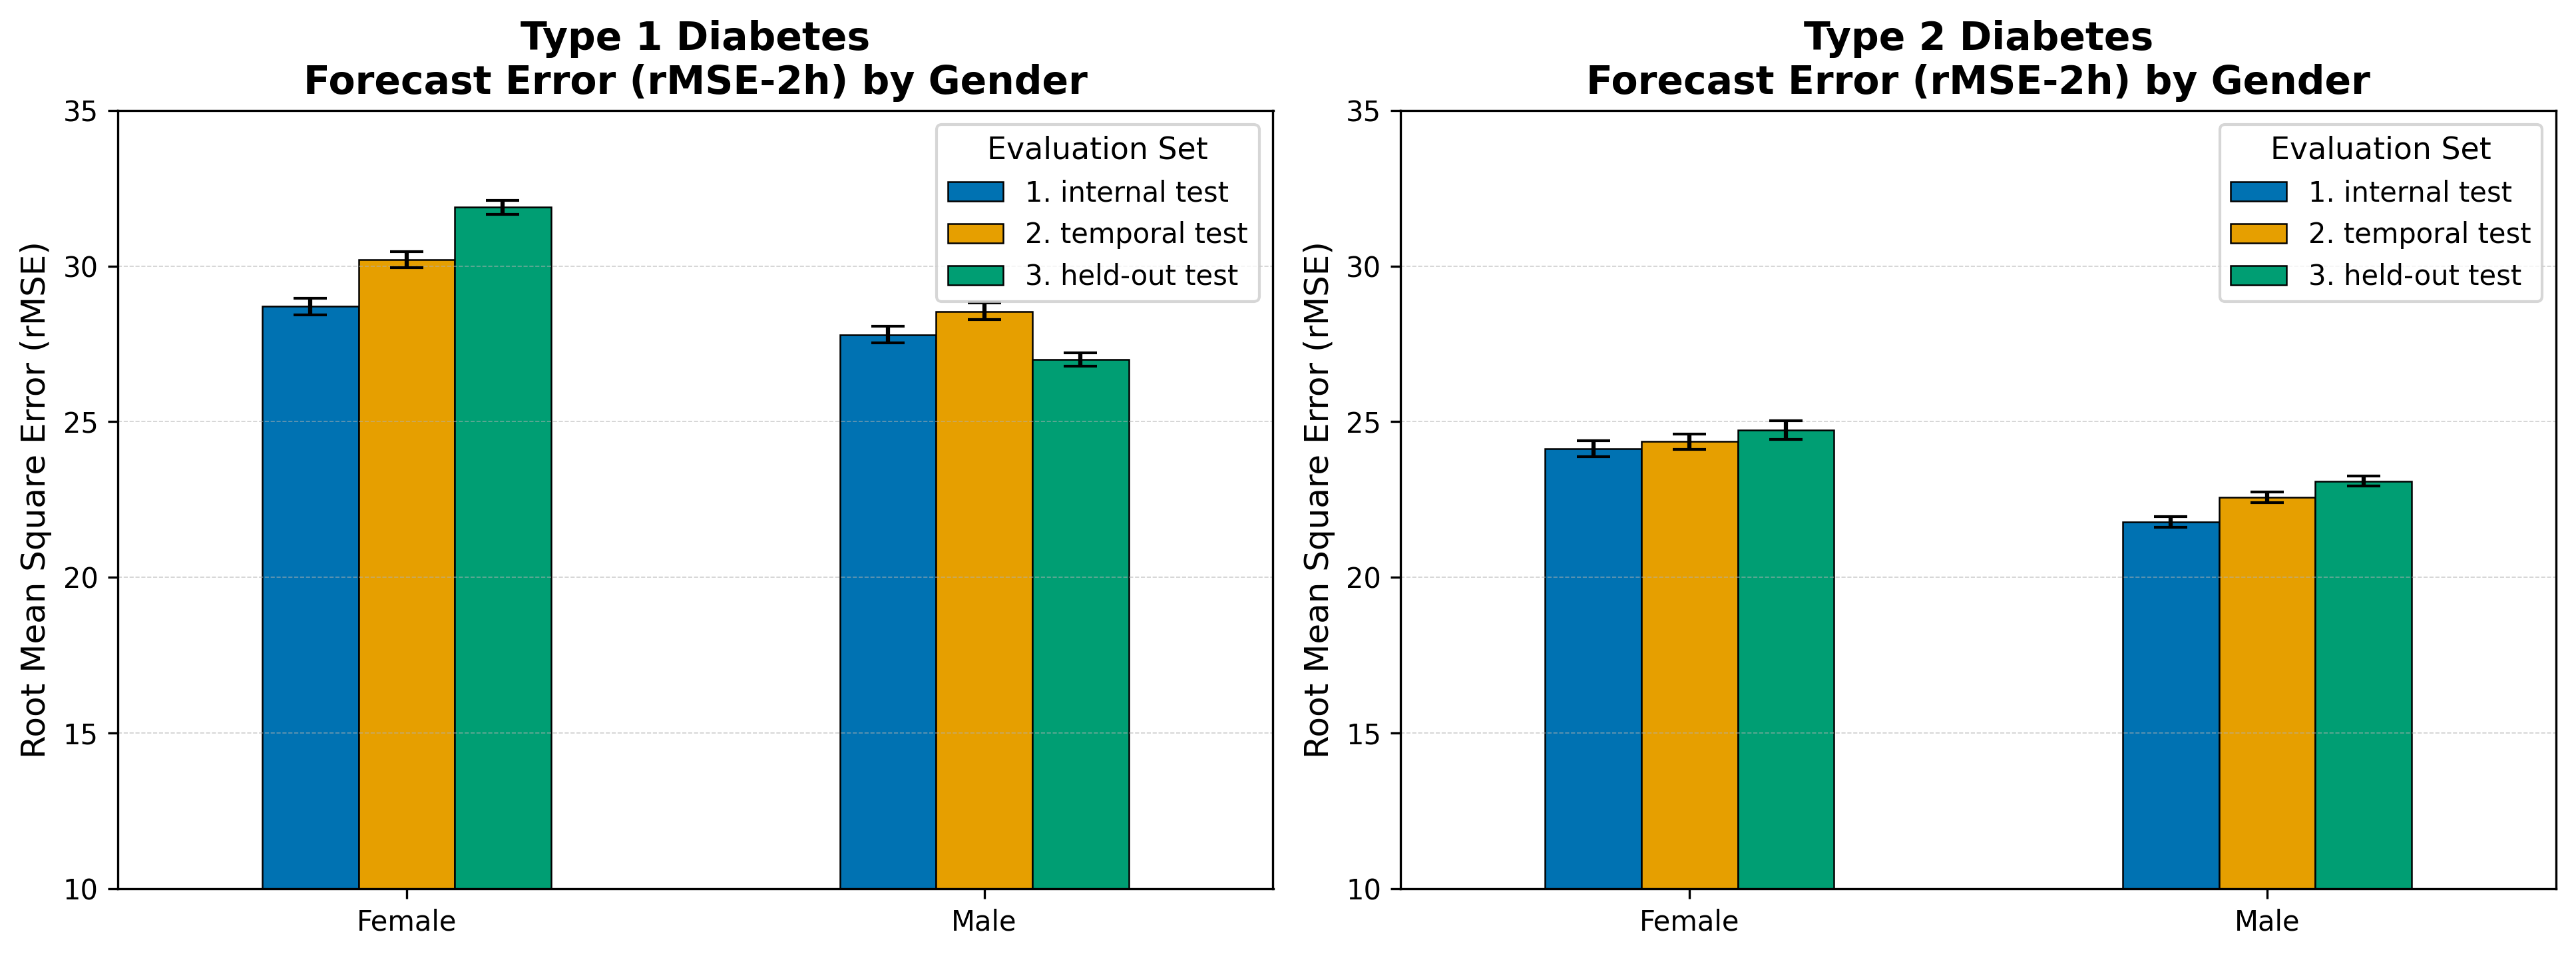

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Define better color palette (colorblind-friendly)
colors = ['#0072B2', '#E69F00', '#009E73']  # Blue, Orange, Green

# Define your variables
metric_horizon = 'rMSE-2h'
min_y = 10
max_y = 35

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=300)

for idx, ax in enumerate(axs):
    diabetes_type = 'Type 1 Diabetes' if idx == 0 else 'Type 2 Diabetes'

    # Select mean and error data
    dfx = results['mean']
    dfx_select = dfx[metric_horizon][diabetes_type]
    dfx_ci = results['ci']
    error = dfx_ci[metric_horizon][diabetes_type]

    # Plot bars
    dfx_select.plot(
        kind='bar',
        yerr=error,
        ax=ax,
        capsize=6,
        color=colors,
        edgecolor='black',
        linewidth=0.6
    )

    # Styling
    ax.set_title(
        f"{diabetes_type}\nForecast Error (rMSE-2h) by Gender",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("Root Mean Square Error (rMSE)", fontsize=12)
    ax.set_ylim([min_y, max_y])
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(title="Evaluation Set", fontsize=10, title_fontsize=11, loc='upper right')

    # Optional: add grid
    ax.grid(axis='y', linestyle='--', linewidth=0.4, alpha=0.6)

# Final layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()


## 3. Metrics by Diabetes Type, Gender, Age Group

In [ ]:
df_case_sample = df_case # df_case[df_case['InOutSplit'] == '3. held-out test'].reset_index(drop=True)
df_case_sample

In [41]:
df_case_sample.columns

Index(['PID', 'ObsDT', 'Gender', 'YearOfBirth', 'DiseaseType', 'cohort', 'Age',
       'Bf24hCGMinfo:VeryLow', 'Bf24hCGMinfo:Low', 'Bf24hCGMinfo:TIR',
       'Bf24hCGMinfo:High', 'Bf24hCGMinfo:VeryHigh', 'Bf24hCGMinfo:TAR',
       'Bf24hCGMinfo:TBR', 'Bf24hCGMinfo:ModeValue',
       'Bf24hCGMinfo:ModePercent', 'Bf24hCGMinfo:recnum',
       'Af2hCGMinfo:VeryLow', 'Af2hCGMinfo:Low', 'Af2hCGMinfo:TIR',
       'Af2hCGMinfo:High', 'Af2hCGMinfo:VeryHigh', 'Af2hCGMinfo:TAR',
       'Af2hCGMinfo:TBR', 'Af2hCGMinfo:ModeValue', 'Af2hCGMinfo:ModePercent',
       'Af2hCGMinfo:recnum', 'Out', 'In', 'Test', 'Valid', 'Train', 'Cohort',
       'Inputs', 'Predict', 'Real', '30m_rMSE', '30m_MAE', '30m_MAEin10',
       '30m_RegionAccu', '30m_InputFeature_mean_glucose',
       '30m_InputFeature_std_glucose', '30m_InputFeature_range_glucose',
       '30m_InputFeature_coef_var', '30m_InputFeature_mean_roc',
       '30m_InputFeature_max_roc', '30m_InputFeature_tir',
       '30m_InputFeature_tar', '30m_InputF

In [ ]:
def cal_x_obs_seq_feature(x_obs_seq, y_real_seq, y_pred_seq):
    # return x_obs_seq
    cgm_sequence = np.array(x_obs_seq)
    diffs = np.diff(cgm_sequence)
    normed = (cgm_sequence - np.min(cgm_sequence)) / (np.max(cgm_sequence) - np.min(cgm_sequence) + 1e-5)

    features = {
        "mean_glucose": np.mean(cgm_sequence),
        "std_glucose": np.std(cgm_sequence),
        "range_glucose": np.max(cgm_sequence) - np.min(cgm_sequence),
        "coef_var": np.std(cgm_sequence) / (np.mean(cgm_sequence) + 1e-5),
        "mean_roc": np.mean(np.abs(diffs)),
        "max_roc": np.max(np.abs(diffs)),
        "tir": np.mean((cgm_sequence >= 70) & (cgm_sequence <= 180)),
        "tar": np.mean(cgm_sequence > 180),
        "tbr": np.mean(cgm_sequence < 70)
    }
    return features



df_case_sample['InputFeature'] = df_case_sample['Inputs'].apply(lambda x: cal_x_obs_seq_feature(x, df_case_sample['Real'], df_case_sample['Predict']))

df_case_sample

In [ ]:
df_features = pd.DataFrame(df_case_sample['InputFeature'].to_list())


df_case_sample = pd.concat([df_case_sample, df_features], axis = 1)

df_case_sample

In [ ]:
columns = ['std_glucose', 'coef_var', 'mean_roc', 'tir', 'tar']
a = df_case_sample.groupby('DiabetesType')[columns].mean()

b = df_case_sample.groupby('AgeGroup')[columns].mean()

c = df_case_sample.groupby('Sex')[columns].mean()


df_report = pd.concat([a, b, c], axis = 0)
df_report 
# 3m

In [57]:

# Define standardized column names with units
columns = ['std_glucose', 'coef_var', 'mean_roc', 'tir', 'tar']
columns_with_unit = {
    'std_glucose': 'Std Glucose (mg/dL)',
    'coef_var': 'Coefficient of Variation',
    'mean_roc': 'Mean Rate of Change (mg/dL/5min)',
    'tir': 'TIR (70-180mg/dL) (%)',
    'tar': 'TAR (>180mg/dL) (%)'
}

# Calculate mean and std
a_mean = df_case_sample.groupby('DiabetesType')[columns].mean()
a_std = df_case_sample.groupby('DiabetesType')[columns].std()

b_mean = df_case_sample.groupby('AgeGroup')[columns].mean()
b_std = df_case_sample.groupby('AgeGroup')[columns].std()

c_mean = df_case_sample.groupby('Sex')[columns].mean()
c_std = df_case_sample.groupby('Sex')[columns].std()

# Set suitable decimal digits for each metric
def get_round_digits(col):
    if col in ['std_glucose', 'mean_roc']:
        return 2
    elif col in ['coef_var', 'tir', 'tar']:
        return 4
    else:
        return 2

def merge_mean_std(mean_df, std_df):
    merged = mean_df.copy()
    for col in mean_df.columns:
        digits = get_round_digits(col)
        merged[col] = mean_df[col].round(digits).astype(str) + " (" + std_df[col].round(digits).astype(str) + ")"
    # Rename columns to standardized names with units
    merged.rename(columns=columns_with_unit, inplace=True)
    return merged

a_merge = merge_mean_std(a_mean, a_std)
b_merge = merge_mean_std(b_mean, b_std)
c_merge = merge_mean_std(c_mean, c_std)

df_report_merge = pd.concat([a_merge, b_merge, c_merge], axis=0)
df_report_merge

,Std Glucose (mg/dL),Coefficient of Variation,Mean Rate of Change (mg/dL/5min),TIR (70-180mg/dL) (%),TAR (>180mg/dL) (%)
Type 1 Diabetes,48.39 (18.89),0.2986 (0.0931),3.57 (1.23),0.6536 (0.2284),0.32 (0.2336)
Type 2 Diabetes,37.68 (16.59),0.2309 (0.0812),3.08 (1.27),0.694 (0.2701),0.2985 (0.2707)
A: 18-39,49.94 (20.39),0.2934 (0.0954),3.88 (1.38),0.6143 (0.2544),0.3648 (0.2588)
B: 40-64,41.49 (18.44),0.2567 (0.0969),3.26 (1.18),0.677 (0.2602),0.3043 (0.2626)
C: 65+,40.59 (15.82),0.2579 (0.0812),3.0 (1.21),0.7143 (0.2194),0.2748 (0.2208)
Female,45.18 (19.22),0.2742 (0.0962),3.57 (1.28),0.654 (0.2527),0.3272 (0.2559)
Male,41.42 (17.88),0.2578 (0.0911),3.13 (1.23),0.6893 (0.2482),0.295 (0.2497)


In [53]:
# c = df_case_sample.groupby('Gender')[columns].mean()

# # c

# 3. Prediction Scenarios 


## 3.1 Hour of the Day

In [90]:
import matplotlib.pyplot as plt

# subcolumn = 'DiseaseType' # 'AgeGroup'
Topic = 'Hour'
SplitSetName = 'Hold-Out Test'

####################################
SplitSetName =  '3.Hold-Out Test'
####################################

subcolumns_list = [['DiabetesType', 'InOutSplit', Topic]]
metric = 'rMSE'
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
# horizon_list = [ '2H']

final_results = {'mean': [], 'sem': [], 'ci': []}
final_counts = []

for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns={value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)
    # Count the number of samples
    # If process_performance_output returns 'count', use it; otherwise, compute manually
    if 'count' in results:
        dfx_count = results['count'].rename(columns={f'count-{horizon}': 'Count'})
        dfx_count['ValueName'] = value_name
        final_counts.append(dfx_count)
    else:
        # If 'count' is not available, compute manually
        group_cols = subcolumns
        dfx_count = df.groupby(group_cols).size().reset_index(name='Count')
        dfx_count['ValueName'] = value_name
        # Add DiabetesType and InOutSplit columns if not present
        for col in ['DiabetesType', 'InOutSplit', Topic]:
            if col not in dfx_count.columns:
                dfx_count[col] = None
        final_counts.append(dfx_count)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci   = pd.concat(final_results['ci'])
df_count = pd.concat(final_counts)

# Make sure df_count has the same structure as df_mean and df_ci
df_count = df_count[['DiabetesType', 'InOutSplit', Topic, 'Count', 'ValueName']]
df_count = df_count.rename(columns={'Count': 'Value'})
df_count = df_count[['DiabetesType', 'InOutSplit', Topic, 'Value', 'ValueName']]

d = {'mean': df_mean, 'ci': df_ci, 'count': df_count}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index=[Topic], columns=['ValueName', 'DiabetesType', 'InOutSplit'], values='Value')
    results[name] = dfx
    print(name)
    display(dfx)


current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.0
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.1
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.2
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.3
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.4
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.5
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.6
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.7
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.8
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.9
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.10
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_Hour.11
current name i

ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                    7.228324         8.443291         8.259669   
1                    6.375274         7.454671         7.556385   
2                    6.198166         6.657366         6.981435   
3                    6.027375         6.534159         6.125201   
4                    5.745588         6.122301         6.195276   
5                    5.733856         6.503465         6.262739   
6                    6.966273         7.097576         6.929282   
7                    7.671092         8.010438         8.134821   
8                    8.146841         8.534324         8.355875   
9                    8.447879         8.771116         8.864232   
10                   8.548225         9.201009         9.320678   
11                   9.096811         9.494174         9.364638   
12                   9.649297        10.888333         9.799258   
13                   9.843103        10.730185        10.376416   
14                   9.784445        10.613696        10.046198   
15                   9.304881        10.337781         9.364965   
16                   9.292992        10.086878         9.534232   
17                   9.968519        10.963015        10.043678   
18                   9.964388        11.390094        10.560293   
19                  10.446569        11.396740        10.852544   
20                  10.187033        10.868234        10.638638   
21                   9.825057        10.823335        10.578018   
22                   9.158954         9.927117        10.474785   
23                   8.284119         9.192151         9.583760   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                    6.807280         7.437701         7.306830   
1                    6.226697         6.693386         6.650938   
2                    5.675960         6.291097         6.363913   
3                    5.356864         5.937040         5.698405   
4                    5.297704         5.593604         5.414762   
5                    5.293985         5.663309         5.272541   
6                    5.821560         6.310029         5.607956   
7                    6.654843         7.195344         6.211275   
8                    6.897906         7.427312         7.180842   
9                    7.339671         7.671738         7.899128   
10                   7.346729         7.823283         7.955724   
11                   7.496676         8.278513         7.663026   
12                   8.626614         8.784236         8.623697   
13                   8.681052         9.392102         9.046952   
14                   8.371034         8.914639         8.927340   
15                   8.097667         8.814669         8.933853   
16                   8.386054         9.115569         8.609424   
17                   8.815921         9.072079         9.029941   
18                   9.031904         9.832954         9.633552   
19                   8.966730        10.029001         9.588912   
20                   8.927194         9.976635         9.399915   
21                   8.781637         9.331217         9.255058   
22                   8.483748         8.784254         8.555450   
23                   7.534748         8.249229         7.747180   

ValueName             rMSE-1h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                         

ci


ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                    0.272207         0.377510         0.239440   
1                    0.253261         0.286049         0.248993   
2                    0.261208         0.247190         0.242306   
3                    0.244822         0.256531         0.199545   
4                    0.247345         0.246072         0.209540   
5                    0.234038         0.247767         0.207329   
6                    0.285542         0.255770         0.239901   
7                    0.295598         0.296110         0.272919   
8                    0.319167         0.295959         0.255197   
9                    0.310248         0.306073         0.261417   
10                   0.317608         0.316945         0.286359   
11                   0.359488         0.331119         0.281619   
12                   0.358268         0.395649         0.284429   
13                   0.358190         0.346806         0.296998   
14                   0.353612         0.337459         0.289141   
15                   0.340678         0.366022         0.258393   
16                   0.345158         0.361811         0.277560   
17                   0.361700         0.384705         0.300780   
18                   0.351942         0.404058         0.306257   
19                   0.368259         0.373411         0.319384   
20                   0.350625         0.358085         0.311285   
21                   0.347343         0.357530         0.290618   
22                   0.325641         0.343548         0.300071   
23                   0.308781         0.333210         0.283914   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                    0.230126         0.252058         0.254859   
1                    0.224091         0.238215         0.232563   
2                    0.202767         0.249498         0.243975   
3                    0.186189         0.206766         0.207102   
4                    0.187651         0.202675         0.200255   
5                    0.188386         0.213591         0.195164   
6                    0.211617         0.229831         0.190213   
7                    0.257480         0.258313         0.213989   
8                    0.262908         0.262715         0.245947   
9                    0.260358         0.264506         0.300586   
10                   0.255703         0.270467         0.278632   
11                   0.269353         0.291297         0.264824   
12                   0.293373         0.330579         0.288254   
13                   0.306358         0.309513         0.294356   
14                   0.277469         0.286400         0.306595   
15                   0.275938         0.287965         0.300645   
16                   0.300772         0.309685         0.274183   
17                   0.315947         0.279554         0.284690   
18                   0.319182         0.329989         0.299086   
19                   0.315693         0.329220         0.276000   
20                   0.292661         0.325655         0.293823   
21                   0.312604         0.302119         0.284651   
22                   0.299777         0.277571         0.266569   
23                   0.262990         0.297647         0.253973   

ValueName             rMSE-1h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                         

count


ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                        2602             2847             3751   
1                        2501             2826             3671   
2                        2590             2965             3569   
3                        2655             2866             3732   
4                        2643             2821             3569   
5                        2565             2846             3717   
6                        2640             2962             3678   
7                        2609             2946             3678   
8                        2567             2979             3678   
9                        2688             2947             3691   
10                       2619             2875             3656   
11                       2546             2911             3717   
12                       2617             2915             3652   
13                       2494             2981             3778   
14                       2578             2982             3682   
15                       2616             2695             3766   
16                       2523             2755             3634   
17                       2491             2809             3728   
18                       2573             2762             3579   
19                       2556             2831             3663   
20                       2609             2752             3619   
21                       2561             2822             3642   
22                       2572             2827             3676   
23                       2564             2840             3660   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                                              
0                        2838             2923             3262   
1                        2816             3092             3221   
2                        2859             3073             3138   
3                        2816             3091             3242   
4                        2853             3088             3240   
5                        2798             3064             3089   
6                        2762             3066             3273   
7                        2651             3048             3191   
8                        2665             2995             3300   
9                        2705             3049             3198   
10                       2800             3122             3162   
11                       2843             3086             3186   
12                       2794             3109             3219   
13                       2671             3206             3186   
14                       2794             2981             3131   
15                       2837             3007             3265   
16                       2719             2954             3160   
17                       2648             3045             3202   
18                       2721             3121             3162   
19                       2679             3073             3263   
20                       2847             3052             3187   
21                       2651             3049             3183   
22                       2748             3016             3132   
23                       2742             2983             3131   

ValueName             rMSE-1h                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
Hour                                         

In [91]:
SplitSetName

'3.Hold-Out Test'

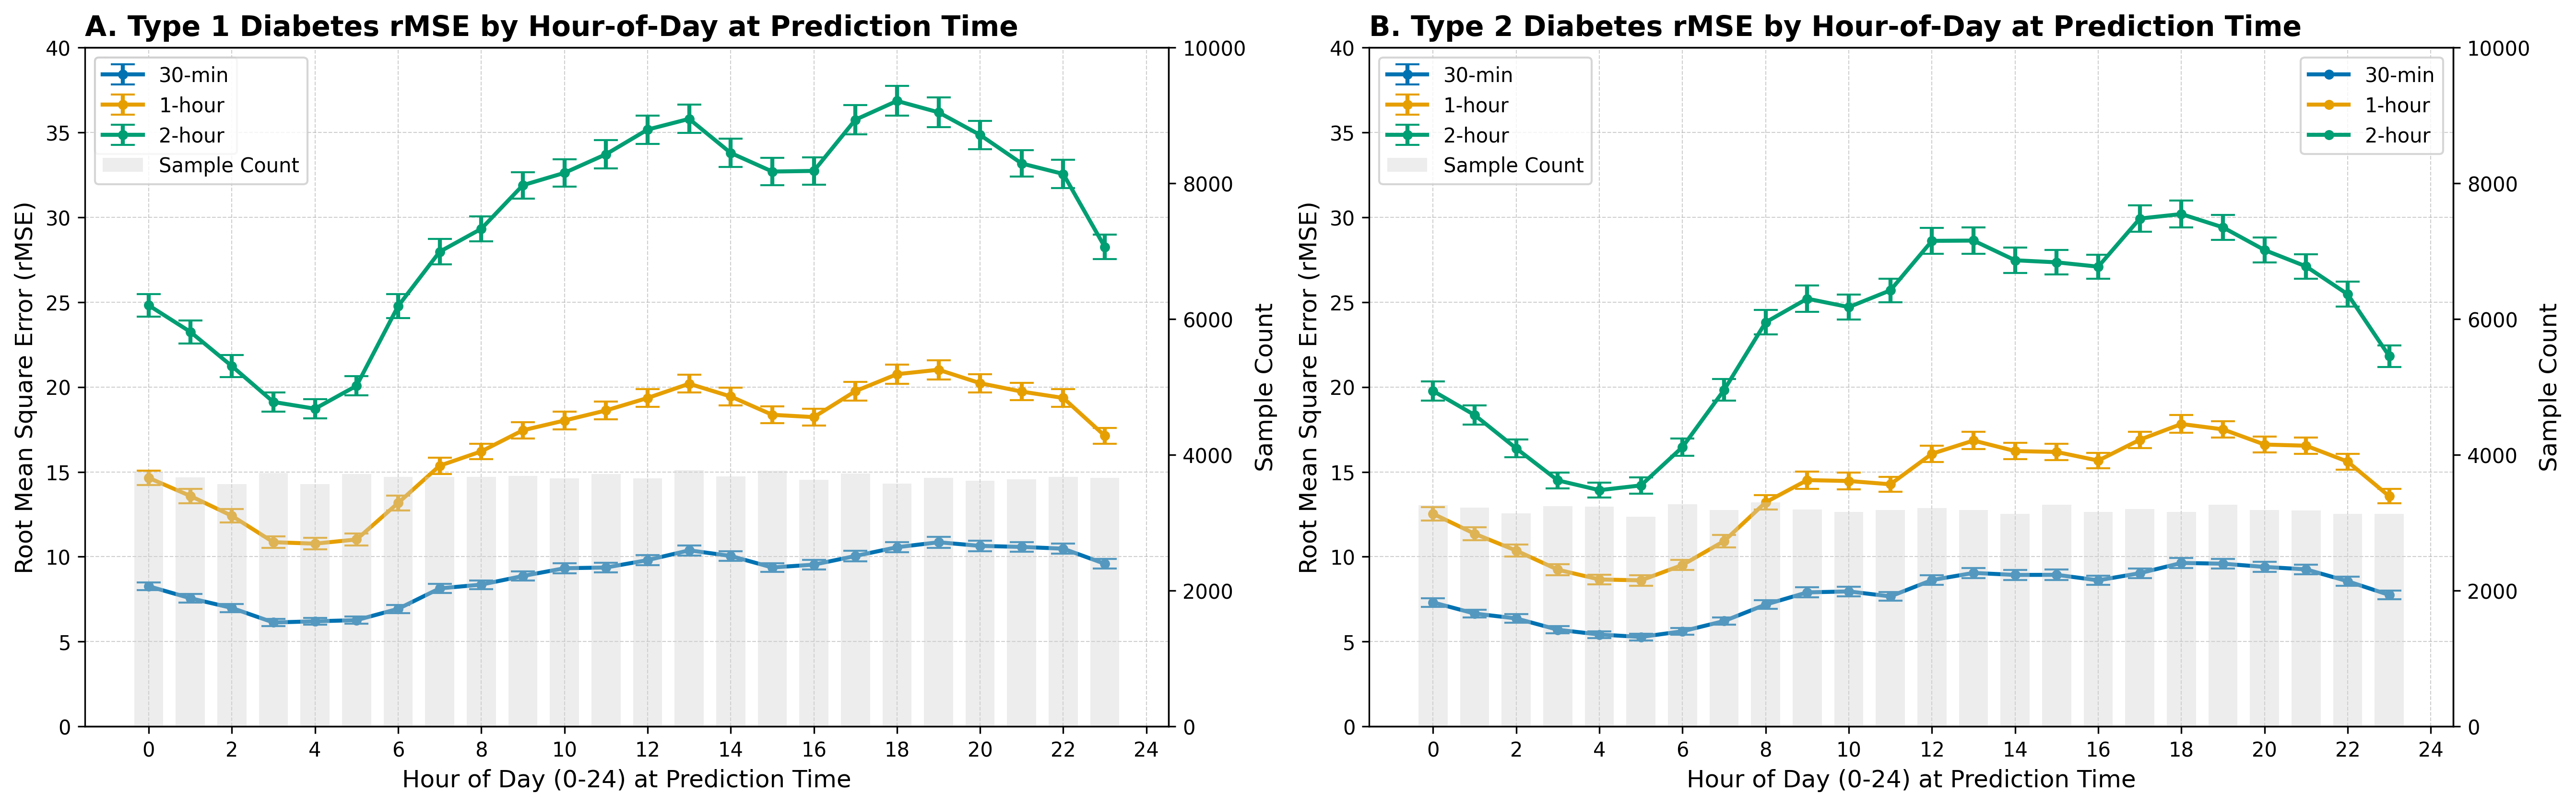

In [94]:
import matplotlib.pyplot as plt
import numpy as np


SplitSetName = '3. held-out test'
# Set up plot aesthetics
min_y = 0
max_y = 40
colors = ['#0072B2', '#E69F00', '#009E73']  # Colorblind-friendly palette
horizon_display = {
    '30m': '30-min',
    '1h': '1-hour',
    '2h': '2-hour'
}

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(18, 6), dpi=300)

for idx, ax in enumerate(axs):
    diabetes_type = 'Type 1 Diabetes' if idx == 0 else 'Type 2 Diabetes'

    dfx = results['mean']
    dfx_ci = results['ci']
    dfx_count = results['count']

    # Plot line (rMSE mean and CI)
    for i, horizon in enumerate(horizon_list):
        metric_horizon = f'{metric}-{horizon}'
        dfx_select = dfx[metric_horizon][diabetes_type][[SplitSetName]]
        error = dfx_ci[metric_horizon][diabetes_type][[SplitSetName]]

        label = horizon_display.get(horizon, horizon)
        dfx_select.columns = [label]
        error.columns = [label]

        dfx_select.plot(
            yerr=error,
            ax=ax,
            capsize=6,
            elinewidth=2,
            linewidth=2,
            marker='o',
            markersize=4,
            color=colors[i],
            label=label
        )

    # Plot sample count as bar (use the first horizon's count)
    count_horizon = f'{metric}-{horizon_list[0]}'
    try:
        count_data = dfx_count[count_horizon][diabetes_type][[SplitSetName]]
    except Exception:
        # In case only one level of index
        count_data = dfx_count[count_horizon][diabetes_type]
        if isinstance(count_data, pd.Series):
            count_data = count_data.to_frame(SplitSetName)
        else:
            count_data = count_data[[SplitSetName]]
    count_data = count_data.copy()
    count_data.columns = ['Count']
    x = count_data.index.values
    ax2 = ax.twinx()
    bar = ax2.bar(
        x,
        count_data['Count'],
        width=0.7,
        color='lightgray',
        alpha=0.4,
        label='Sample Count'
    )
    ax2.set_ylabel('Sample Count', fontsize=12)
    ax2.set_ylim([0, 10000])
    ax2.tick_params(axis='y', labelsize=10)
    ax2.spines['right'].set_visible(True)
    ax2.spines['left'].set_visible(False)
    # Merge legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles1 + handles2, labels1 + labels2, 
        fontsize=10, 
        # title="Prediction Horizon / Sample Count", 
        # title_fontsize=11, 
        loc='upper left'
        )

    # Axis, title, grid
    # Axes formatting
    ID = 'A' if idx == 0 else 'B'   
    ax.set_title(
        f"{ID}. {diabetes_type} rMSE by Hour-of-Day at Prediction Time",
        fontsize=14,
        fontweight='bold',
        loc='left' 
    )
    ax.set_xlabel("Hour of Day (0-24) at Prediction Time", fontsize=12)
    ax.set_ylabel("Root Mean Square Error (rMSE)", fontsize=12)
    ax.set_ylim([min_y, max_y])
    ax.set_xticks(np.arange(0, 25, 2))
    ax.set_xticklabels(np.arange(0, 25, 2))
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


# 3.2 Glucose Value Counts

In [67]:
# df_case

In [68]:
df_case['CurrentGluco'] = df_case['Inputs'].apply(lambda x: x[-1])# .value_counts



def map_current_gluco(x):
    if x <= 50:
        return 50
    elif x >= 400:
        return 400
    else:
        return int((x + 9) / 10) * 10

df_case['CurrentGluco'] = df_case['CurrentGluco'].apply(map_current_gluco)



# df_case['CurrentGluco'] = df_case['CurrentGluco'].apply(lambda x: x if x >= 40 else 40)

In [84]:
import matplotlib.pyplot as plt

# subcolumn = 'DiseaseType' # 'AgeGroup'
Topic = 'CurrentGluco'
SplitSetName = 'Hold-Out Test'

####################################
SplitSetName =  '3.Hold-Out Test'
####################################

subcolumns_list = [['DiabetesType', 'InOutSplit', Topic]]
metric = 'rMSE'
focus_on_list = []
horizon_list = ['30m', '1h', '2h']
# horizon_list = [ '2H']

final_results = {'mean': [], 'sem': [], 'ci': []}
final_counts = []

for horizon in horizon_list:
    results = process_performance_output(df, subcolumns_list, focus_on_list, metric, horizon)
    value_name = f'{metric}-{horizon}'
    subcolumns = subcolumns_list[0]
    index = subcolumns[0]
    columns = subcolumns[1:]
    for name, dfx in results.items():
        dfx = dfx.rename(columns={value_name: 'Value'})
        dfx['ValueName'] = value_name
        final_results[name].append(dfx)
    # Count the number of samples
    # If process_performance_output returns 'count', use it; otherwise, compute manually
    if 'count' in results:
        dfx_count = results['count'].rename(columns={f'count-{horizon}': 'Count'})
        dfx_count['ValueName'] = value_name
        final_counts.append(dfx_count)
    else:
        # If 'count' is not available, compute manually
        group_cols = subcolumns
        dfx_count = df.groupby(group_cols).size().reset_index(name='Count')
        dfx_count['ValueName'] = value_name
        # Add DiabetesType and InOutSplit columns if not present
        for col in ['DiabetesType', 'InOutSplit', Topic]:
            if col not in dfx_count.columns:
                dfx_count[col] = None
        final_counts.append(dfx_count)

df_mean = pd.concat(final_results['mean'])
df_sem  = pd.concat(final_results['sem'])
df_ci   = pd.concat(final_results['ci'])
df_count = pd.concat(final_counts)

# Make sure df_count has the same structure as df_mean and df_ci
df_count = df_count[['DiabetesType', 'InOutSplit', Topic, 'Count', 'ValueName']]
df_count = df_count.rename(columns={'Count': 'Value'})
df_count = df_count[['DiabetesType', 'InOutSplit', Topic, 'Value', 'ValueName']]

d = {'mean': df_mean, 'ci': df_ci, 'count': df_count}
results = {}
for name, dfx in d.items():
    dfx = dfx.pivot(index=[Topic], columns=['ValueName', 'DiabetesType', 'InOutSplit'], values='Value')
    results[name] = dfx
    print(name)
    display(dfx)


current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.50
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.60
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.70
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.80
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.90
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.100
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.110
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.120
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.130
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGluco.140
current name is : DiabetesType.Type 1 Diabetes_InOutSplit.1. internal test_CurrentGlu

ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                  12.794414        23.827178        10.623863   
60                  11.005677        13.983795        10.372685   
70                   9.612632        10.668883        10.193670   
80                   8.546436         9.406490         9.319726   
90                   7.845847         8.299099         8.614569   
100                  6.985271         7.667052         8.110154   
110                  7.119124         7.400870         7.602120   
120                  7.114374         7.575298         7.389651   
130                  7.212013         7.913804         7.626896   
140                  7.465458         8.064025         7.688840   
150                  7.680431         8.375157         7.879825   
160                  8.112961         8.619878         8.213859   
170                  8.234601         9.118919         8.456533   
180                  8.524702         9.182787         8.888104   
190                  8.756807         9.503777         9.009531   
200                  9.017599         9.829833         9.747647   
210                  9.681160        10.537902         9.729422   
220                  9.575255        10.213721        10.232915   
230                  9.892392        10.664476        10.442310   
240                  9.821295        10.915786        10.725194   
250                 10.287450        11.542806        10.605492   
260                 10.222456        11.046393        11.332249   
270                 10.577772        11.325251        11.838616   
280                 10.363295        11.873230        12.317844   
290                 11.258736        13.199424        11.485548   
300                 10.793498        12.744301        12.404788   
310                 11.631837        13.335682        13.018586   
320                 12.495818        12.116626        12.774752   
330                 11.541709        13.328158        12.077163   
340                 10.840658        12.547380        13.039480   
350                 11.709087        11.790472        12.423454   
360                 11.349524        13.517577        14.089045   
370                 10.825734        13.223333        13.123221   
380                 13.188800        13.736692        15.440561   
390                 10.689643        15.645728        15.338660   
400                 11.716364        10.321814        15.714850   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                  12.671905        29.954194        12.938582   
60                  13.074559        12.677595        13.565181   
70                   9.888732        11.994597        10.997709   
80                   7.050805         8.193760         8.234203   
90                   6.555389         6.961428         6.658623   
100                  6.125883         6.422211         6.039916   
110                  6.260574         6.535152         5.818318   
120                  6.100549         6.446735         6.147539   
130                  6.463678         6.911156         6.255085   
140                  6.607613         7.007381         6.602268   
150                  6.983768         7.361662         7.013171   
160                  7.147278         7.784883         7.341356   
170                  7.596228         8.212393         7.448538   
180                  7.905895         8.124259         8.190845   
190                  8.111640         8.880521         8.382689   
200                  8.395176         9.082322

ci


ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                   2.136634         5.505944         0.943814   
60                   1.147535         1.222868         0.691503   
70                   0.636403         0.636468         0.501504   
80                   0.415551         0.435390         0.388004   
90                   0.335785         0.325503         0.311545   
100                  0.242543         0.254368         0.258432   
110                  0.224751         0.211558         0.201375   
120                  0.206094         0.209095         0.187647   
130                  0.214261         0.213235         0.181625   
140                  0.214165         0.216400         0.172419   
150                  0.235007         0.225259         0.172352   
160                  0.245331         0.246320         0.193536   
170                  0.252637         0.255930         0.197994   
180                  0.294283         0.278510         0.230083   
190                  0.302979         0.301695         0.236335   
200                  0.324857         0.339567         0.279373   
210                  0.392309         0.416794         0.293780   
220                  0.381962         0.401014         0.340055   
230                  0.442494         0.439376         0.364688   
240                  0.457182         0.464068         0.430811   
250                  0.515565         0.572436         0.431190   
260                  0.560400         0.580838         0.515969   
270                  0.659390         0.593218         0.546187   
280                  0.652862         0.758710         0.663927   
290                  0.787552         1.112587         0.678900   
300                  0.821024         0.911590         0.763040   
310                  0.990293         1.103031         0.868424   
320                  1.273174         1.057307         1.068758   
330                  1.137497         1.379866         0.946657   
340                  1.167053         1.211586         1.121958   
350                  1.415286         1.295673         1.261691   
360                  1.702016         1.520078         1.608192   
370                  1.650768         2.018456         1.526474   
380                  2.732698         1.933995         2.763922   
390                  1.996828         3.153233         3.562755   
400                  1.991586         1.844534         3.031747   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                   6.218622        16.433655         2.636137   
60                   2.684927         2.398157         1.898134   
70                   1.359186         1.464211         1.061444   
80                   0.588612         0.659712         0.599987   
90                   0.372049         0.372126         0.334862   
100                  0.240309         0.249452         0.217392   
110                  0.196718         0.198132         0.163196   
120                  0.161844         0.168665         0.162997   
130                  0.160934         0.172344         0.153765   
140                  0.160738         0.165983         0.158071   
150                  0.176458         0.169597         0.177248   
160                  0.184948         0.192664         0.176248   
170                  0.204267         0.217994         0.189735   
180                  0.225032         0.218335         0.243407   
190                  0.251038         0.265554         0.244816   
200                  0.280821         0.291096

count


ValueName            rMSE-30m                                    \
DiabetesType  Type 1 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                        145              163              541   
60                        384              440              797   
70                        931              958             1444   
80                       1706             1846             2157   
90                       2562             2742             2972   
100                      3563             3718             4145   
110                      4405             4907             5400   
120                      4803             5396             6075   
130                      4720             5345             6582   
140                      4509             5028             6894   
150                      4224             4842             6579   
160                      3860             4339             5905   
170                      3517             3988             5575   
180                      3037             3588             4726   
190                      2878             3095             4393   
200                      2486             2755             3837   
210                      2094             2264             3252   
220                      1939             2029             2748   
230                      1576             1832             2420   
240                      1429             1647             2037   
250                      1243             1276             1728   
260                      1026             1109             1432   
270                       826              975             1178   
280                       777              805             1016   
290                       609              660              867   
300                       546              558              731   
310                       381              447              601   
320                       373              409              463   
330                       275              304              363   
340                       243              271              327   
350                       208              212              249   
360                       168              194              199   
370                       143              150              149   
380                       100              130              107   
390                        84              103               97   
400                       209              237              200   

ValueName                                                        \
DiabetesType  Type 2 Diabetes                                     
InOutSplit   1. internal test 2. temporal test 3. held-out test   
CurrentGluco                                                      
50                         21               31              134   
60                         68               79              193   
70                        213              248              419   
80                        646              726              973   
90                       1618             1723             1983   
100                      2985             3089             3569   
110                      4370             4864             5221   
120                      5606             6178             6275   
130                      6133             6979             6681   
140                      6045             6811             6693   
150                      5595             6347             6431   
160                      5124             5445             5832   
170                      4433             4709             5062   
180                      3927             4069             4309   
190                      3390             3529             3656   
200                      2817             3118

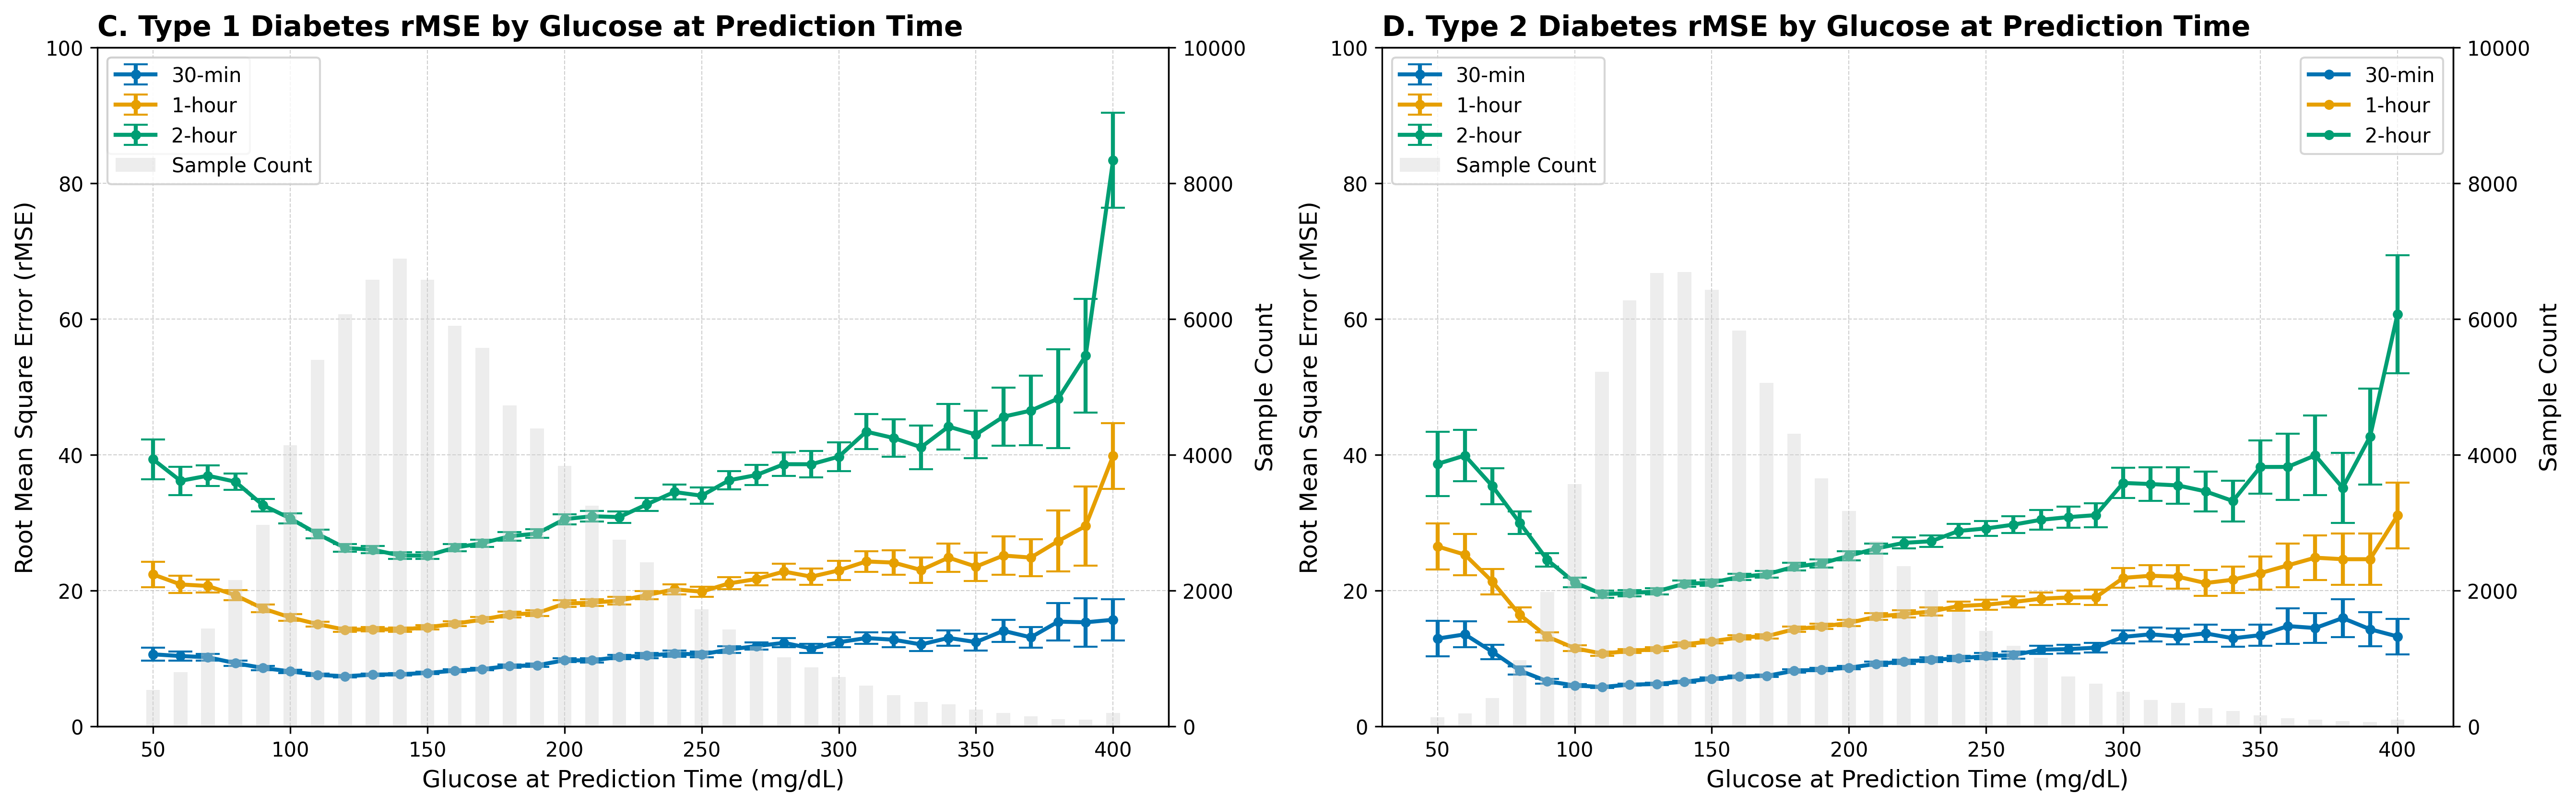

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SplitSetName = '3. held-out test'
min_y = 0
max_y = 100
colors = ['#0072B2', '#E69F00', '#009E73']  # Colorblind-friendly palette
horizon_display = {
    '30m': '30-min',
    '1h': '1-hour',
    '2h': '2-hour'
}

fig, axs = plt.subplots(1, 2, figsize=(18, 6), dpi=300)

for idx, ax in enumerate(axs):
    diabetes_type = 'Type 1 Diabetes' if idx == 0 else 'Type 2 Diabetes'

    dfx = results['mean']
    dfx_ci = results['ci']
    dfx_count = results['count']

    for i, horizon in enumerate(horizon_list):
        metric_horizon = f'{metric}-{horizon}'
        dfx_select = dfx[metric_horizon][diabetes_type][[SplitSetName]]
        error = dfx_ci[metric_horizon][diabetes_type][[SplitSetName]]

        label = horizon_display.get(horizon, horizon)

        # Get index and convert to bin center if needed
        x = dfx_select.index.values
        if not np.issubdtype(x.dtype, np.number):
            try:
                bin_centers = np.array([np.mean([float(s) for s in val.replace('–', '-').split('-')]) for val in x])
                x = bin_centers
                dfx_select.index = x
                error.index = x
            except Exception:
                print("Error converting bin labels to numeric centers")

        dfx_select.columns = [label]
        error.columns = [label]

        dfx_select.plot(
            yerr=error,
            ax=ax,
            capsize=6,
            elinewidth=2,
            linewidth=2,
            marker='o',
            markersize=4,
            color=colors[i],
            label=label
        )

    # Sample count bar plot (based on first horizon)
    count_horizon = f'{metric}-{horizon_list[0]}'
    try:
        count_data = dfx_count[count_horizon][diabetes_type][[SplitSetName]]
    except Exception:
        count_data = dfx_count[count_horizon][diabetes_type]
        if isinstance(count_data, pd.Series):
            count_data = count_data.to_frame(SplitSetName)
        else:
            count_data = count_data[[SplitSetName]]

    count_data = count_data.copy()
    count_data.columns = ['Count']
    x_bar = count_data.index.values
    if not np.issubdtype(x_bar.dtype, np.number):
        try:
            x_bar = np.array([np.mean([float(s) for s in val.replace('–', '-').split('-')]) for val in x_bar])
            count_data.index = x_bar
        except Exception:
            print("Error converting bar bin labels to numeric centers")

    ax2 = ax.twinx()
    ax2.bar(
        count_data.index.values,
        count_data['Count'],
        width=5,
        color='lightgray',
        alpha=0.4,
        label='Sample Count'
    )
    ax2.set_ylabel('Sample Count', fontsize=12)
    ax2.set_ylim([0, 10000])
    ax2.tick_params(axis='y', labelsize=10)
    ax2.spines['right'].set_visible(True)
    ax2.spines['left'].set_visible(False)

    # Merge legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(
        handles1 + handles2,
        labels1 + labels2,
        fontsize=10,
        # title="Prediction Horizon / Sample Count",
        title_fontsize=11,
        loc='upper left'
    )

    # Axes formatting
    ID = 'C' if idx == 0 else 'D'   
    ax.set_title(
        f"{ID}. {diabetes_type} rMSE by Glucose at Prediction Time",
        fontsize=14,
        fontweight='bold',
        loc='left' 
    )
    ax.set_xlabel("Glucose at Prediction Time (mg/dL)", fontsize=12)
    ax.set_ylabel("Root Mean Square Error (rMSE)", fontsize=12)
    ax.set_ylim([min_y, max_y])
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()
